# Machine Learning Exercise #4 - Neural Networks

이 연습을 위해 우리는 손으로 쓴 숫자 데이터 세트를 다시 다루겠습니다. 이번에는 역전파(back-propagation)와 순전파(forward-propagation) 신경망을 사용합니다. 우리는 역전파 알고리즘을 통해 신경망 비용 함수와 기울기 계산의 정규화되지 않은 것과 정규화 된 버전을 모두 구현할 것입니다. 랜덤 가중치 초기화와 네트워크를 사용하여 예측을 수행하는 방법도 구현할 것입니다.

데이터는 연습 3에서 사용한 데이터 세트와 동일하므로, 다음과 같이 코드를 다시 사용하여 데이터를 로드합니다. 나중에 이들을 필요로 할 것이므로(그리고 자주 사용하기도 합니다), 유용한 변수로 미리 만들어 보겠습니다.

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = h5py.File('ex3data2.h5', 'r')
print(list(data.keys()))
X = np.array(data['X'])
y = np.reshape(data['y'], (data['y'].shape[0], 1))
print(X.shape, y.shape)
data.close()

['X', 'y']
(5000, 400) (5000, 1)


### 자료 시각화

다음의 코드는 데이터를 2 차원 플롯으로 표시합니다. 이것은 이전 연습에서 사용한 것과 동일한 데이터 세트입니다. 5000 개의 학습 예제가 있으며 각 연습 예제는 20x20 픽셀 회색 음영 이미지입니다. 각 픽셀은 해당 위치에서 그레이 스케일 강도를 나타내는 부동 소수점 숫자로 표시됩니다. 20 x 20 픽셀 격자는 400 차원 벡터로 주어집니다. 이 훈련 예제는 우리의 데이터 행렬 $X$에서 하나의 행이 됩니다.이 행렬은 손으로 쓴 자릿수 이미지에 대한 모든 행이 훈련 예제 인 5000 x 400 행렬 $X$를 제공합니다.
$$ X = \begin{bmatrix}
        - (x^{(1)})^T -\\
        - (x^{(2)})^T - \\
        \vdots\\
        - (x^{(m)})^T -\\
         \end{bmatrix}
         $$

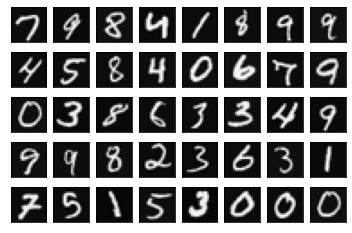

In [2]:
select = np.random.randint(5000, size=40)

fig, axs = plt.subplots(5,8,subplot_kw={'xticks': [], 'yticks': []})

for i in np.arange(5):
    for j in np.arange(8):
        one = X[select[i*8+j],:].reshape(20,20)
        axs[i][j].imshow(one.T, cmap='gray')
    
plt.show()

훈련 세트의 두 번째 파트는 트레이닝 세트의 레이블을 포함하는 5000 차원 벡터입니다. "0" 자릿수는 "10"으로 표시되고 숫자 "1"-"9"는 자연 순서대로 "1"-"9"로 표시됩니다.

### 모델 표현

우리의 신경 네트워크는 아래의 그림 2에 나와 있습니다. 입력 층, 은닉 층 및 출력 층의 3개 층이 있습니다. 입력 값은 숫자 이미지의 픽셀 값입니다. 이미지의 크기가 20×20 이므로 400개의 입력 층 노드를 제공합니다 (항상 +1을 출력하는 추가 바이어스 노드 제외). 이전과 마찬가지로, 학습 데이터는 변수 $X$와 $y$에 로드됩니다.  

<img src="fig2.png" width=350>

이미 우리가 훈련 한 네트워크 매개 변수 집합 ($\Theta^{(1)}, \Theta^{(2)}$)이 제공되었습니다. 이것들은 ex4weights2.h5 저장되어 있으며, Theta1과 Theta2로 읽혀집니다. 매개 변수에는 두 번째 층에 25 노드과 10 개의 출력 노드(숫자 10개 클래스에 해당)이 있는 신경망에 맞는 크기를 갖습니다.

### 순방향 전파 및 비용 함수

이제 신경망에 대한 비용 함수와 그래디언트를 구현할 것입니다. 먼저 다음의 코드를 완성하여 비용을 반환하십시오.

신경망에 대한 비용 함수(정규화되지 않은)는 다음과 같습니다.

$$ J(\theta) = {1\over m} \sum_{i=1}^m \sum_{k=1}^K [-y_k^{(i)} \log(h_\theta(x^{(i)})_k) - (1 - y_k^{(i)}) \log(1-h_\theta(x^{(i)})_k)] $$

여기서 $h_\theta (x^{(i)})$는 그림 2와 같이 계산되고, K = 10은 가능한 레이블의 총 수입니다. $h (x^{(i)})_k = a_k^{(3)}$ 는 k 번째 출력 단위의 활성화(출력값)이다. 또한 원래의 레이블 (변수 y에서)은 1, 2, ..., 10 이었지만 신경망을 학습 할 목적으로 레이블을 0 또는 1 만 포함하는 벡터로 다음처럼 표시된 원핫(one-hot) 벡터로 다시 코딩해야합니다. 
$$ y = \begin{bmatrix}
        1\\ 0\\ 0\\ \vdots\\ 0\\
         \end{bmatrix}
        ,
        \begin{bmatrix}
        0\\ 1\\ 0\\ \vdots\\ 0\\
         \end{bmatrix}
         , \cdots \text{ or },
         \begin{bmatrix}
        0\\ 0\\ 0\\ \vdots\\ 1\\
         \end{bmatrix}
         $$


우리는 y 레이블을 원핫(one-hot) 인코딩해야 합니다. one-hot 인코딩은 클래스 레이블 n (k 클래스들 중에서)을 길이가 k 인 벡터로 바꾸어줍니다. 여기서 인덱스 n은 hot(1)이고, 나머지는 0 입니다. Scikit-learn은 이것을 위해 사용할 수 있는 유틸리티가 내장되어 있습니다.



In [3]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories='auto', sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [5]:
y[2000], y_onehot[2000,:]

(array([4], dtype=uint8), array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]))

이 실습을 위해 구축 할 신경망에는 인스턴스 데이터 크기(400 + 바이어스 단위)의 입력 레이어와, 25개 단위(바이어스 단위를 포함하면 26)가 있는 히든 레이어와 함께, 클래스 레이블에 대한 우리의 one-hot 인코딩에 해당하는 10 단위의 출력 레이어가 있습니다. 

우리가 구현해야 할 첫 번째 부분은 주어진 네트워크 매개 변수 집합에 대한 손실을 평가하는 비용 함수입니다. 다음은 비용을 계산하는 데 필요한 함수입니다.

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0] # 훈련자료 수
    
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = np.dot(a1, theta1.T)
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [8]:
def cost0(X, y, theta1, theta2):
    m = X.shape[0]
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    # Problem(1) - score 10 ========= ~ 3 lines of code
    for i in range(m):
        first_term =   
        second_term =  
        J +=  
    # ===========================================================
    J = J / m
    
    return J

시그모이드 함수는 이전에 사용했으므로 새 것이 아닙니다. forward-propagate 함수는 현재 주어진 매개변수로 각 학습 인스턴스에 대한 가설의 결과를 계산합니다. 출력 형태는 y에 대한 one-hot 인코딩과 동일해야 합니다. 우리는 이 사실을 빨리 테스트하여 예상대로 작동하고 있음을 확신 할 수 있습니다 (중간 단계도 나중에 유용하므로 반환됩니다).

코딩이 완료되면 Theta1과 Theta2에 대한 매개 변수 집합을 사용하여 cost 함수를 호출합니다. 비용은 약 0.2091074 입니다.

In [9]:
rf = h5py.File("ex4weights2.h5", "r")
print(list(rf.keys()))
theta1 = np.array(rf['Theta1'])
theta2 = np.array(rf['Theta2'])
rf.close()
print(theta1.shape, theta2.shape)
cost0(X, y_onehot, theta1, theta2)

['Theta1', 'Theta2']
(25, 401) (10, 26)


0.20910741024935656

In [10]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
reg_lambda = 1

# randomly initialize a parameter array of the size of the full network's parameters
# Problem 2 (score = 5) =============================================
params_size =  
# ====================================================================
params = (np.random.random(size=params_size) - 0.5) * 0.25

m = X.shape[0]
X = np.matrix(X)
y = np.matrix(y)

# unravel the parameter array into parameter matrices for each layer
theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [11]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

비용 함수는 가설 행렬 h를 계산 한 후 비용 방정식을 적용하여 y와 h 간의 총 오류를 계산합니다.

In [12]:
cost0(X, y_onehot, theta1, theta2)

6.8731070840562705

다음 단계는 비용 함수에 정규화를 추가하는 것입니다. 연습 본문을 따라 가면서 마지막 방정식이 복잡해 보인다고 생각한다면, 이 것은 정말 보기 흉한 것처럼 보입니다. 실제로 보이는 것처럼 복잡하지는 않습니다. 사실, 정규화 용어는 단순히 우리가 이미 계산한 비용에 추가된 것입니다. 다음은 수정된 비용 함수입니다.

정규화된 신경망 비용함수:
$$h_\theta(x) \in \mathbb{R}^K \quad (h_\theta(x))_i = i^{th} \text{output}$$

$$J(\theta) = -{1 \over m} \left[  \sum_{i=1}^m \sum_{k=1}^K y_k^{(i)} \log (h_\theta(x^{(i)}))_k + (1- y_k^{(i)}) \log(1-(h_\theta(x^{(i)})_k) ) \right] \\
 + {\lambda \over 2m} \sum_{l=1}^{L-1}\sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} (\Theta_{ji}^{[l]})^2$$
 

In [13]:
def cost(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost
    J = 0
    # Same as Problem 1 (score 10) =============
    for i in range(m):
        first_term =   
        second_term =  
        J +=  
    # ======================================
    J = J / m

    # add the cost regularization term
    # Problem 3 (Score 5) ============ ~ 1 line of code
    J +=  
    # ======================================
    return J

cost(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)

6.878460415321538

다음은 back-propagation 알고리즘입니다. Back-propagation 은 훈련 데이터에서 네트워크의 오류를 줄이는 매개 변수 업데이트를 계산합니다. 우리가 먼저 필요로 하는 것은 우리가 이전에 생성한 시그모이드 함수의 그래디언트를 계산하는 함수입니다.

In [16]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

이제 그라디언트를 계산하기 위해 역전파(back-propagation)를 구현할 준비가 되었습니다. 역전파에 필요한 계산이 비용 함수에서 요구되는 계산의 상위 집합이기 때문에 실제로 비용 함수를 확장하여 역전파를 수행하고 비용과 그라디언트를 모두 반환합니다.

#### 역전파 알고리즘

훈련자료 $ \{ (x^{(1)},y^{(1)}),(x^{(2)},y^{(2)}),\cdots,(x^{(m)},y^{(m)}),  \} $

Set $\Delta_{ij}^{[l]} = 0 \quad (\text{ for all }l, i, j)$ 

For $i = 1 \text{ to } m$

$\quad \text{Set } a^{[1]} = x^{(i)} $

$\quad a^{[l]} \text{ 계산을 위해서 순방향 전파 시행 } (\text{ for } l=2,3,\cdots, L)$

$\quad y^{(i)} \text{ 를 사용하여 } \delta^{[L]} = a^{[L]} -y^{(i) }\text{ 계산 }$

$\quad \delta^{[L-1]}, \delta^{[L-2]}, \cdots, \delta^{[1]} \text{ 계산 }$

$\quad \quad \delta^{[l]} = (\Theta^{[l]})^T \delta^{[l+1]} .* g'(z^{[l]}) \quad$ where $ \quad g'(z^{[l]}) = a^{[l]}.*(1-a^{[l]})$ 

$\quad \Delta_{ij}^{[l]} := \Delta_{ij}^{[l]} + a_j^{[l]} \delta_i^{[l+1]} $

$ D_{ij}^{[l]} := {1 \over m} \Delta_{ij}^{[l]} +{\lambda \over m} \Theta_{ij}^{[l]} \text{ if } j \ne 0 $ 

$ D_{ij}^{[l]} := {1 \over m} \Delta_{ij}^{[l]} \text{ if } j = 0 $ 

$${\partial \over \partial \Theta_{ij}^{[l]}} J(\theta) = D_{ij}^{[l]} $$

In [17]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    # Same as Problem 1 (score 10) =============
    for i in range(m):
        first_term =   
        second_term =  
        J += 
    # ======================================
    J = J / m
    
    # add the cost regularization term
    # Same as Problem 3 (score 5) =============
    J +=  
    # ========================================
    
    # perform backpropagation
    # Problem 4 (Score 15) ========== ~ 10 lines of code
    for t in range(m):
        a1t =                # (1, 401)
        z2t =                # (1, 25)
        a2t =                # (1, 26)
        ht =                 # (1, 10)
        yt =                 # (1, 10)
        
        d3t =                # (1, 10)
        
        z2t =                                         # (1, 26)
        d2t =                                         # (1, 26)
        
        delta1 =  
        delta2 =  
    # ================================    
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

(왜 우리가 이 모든 계산을 하는지 이해하는 것 외에) backprop 함수 계산의 가장 어려운 부분은 행렬 차원을 올바르게 얻는 것입니다. 즉, np.dot(A,B) 와 np.multiply(A, B) = A*B를 혼동 할 때 혼란스럽다면 혼자가 아닙니다. 기본적으로 전자는 행렬 곱셈이고 후자는 요소 단위의 곱셈입니다 (A 또는 B는 스칼라 값이 아니라면 상관 없습니다). 

어쨌든 함수가 우리가 기대하는 바를 반환하는지 테스트 해 봅시다.

In [18]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)
J, grad.shape

(6.878460415321538, (10285,))

그라데이션 계산에 정규화를 추가하여 백 드롭 기능을 수행 할 수있는 또 하나의 수정이 있습니다. 최종 정식 버전은 아래와 같습니다.

In [19]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg_lambda):
    m = X.shape[0]
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # initializations
    J = 0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    # Same as Problem 1 (score 10) ====================
    for i in range(m):
        first_term =  
        second_term =  
        J +=  
    # ======================================
    J = J / m

    # add the cost regularization term
    # Same as Problem 3 (Score 5) ========================
    J += 
    # ===============================
    
    # perform backpropagation
    # Same as Problem 4 (Score 15) ========================
    for t in range(m):
        a1t =                # (1, 401)
        z2t =                # (1, 25)
        a2t =                # (1, 26)
        ht =                 # (1, 10)
        yt =                 # (1, 10)
        
        d3t =                # (1, 10)
        
        z2t =                                             # (1, 26)
        d2t =                                             # (1, 26)
        
        delta1 = 
        delta2 =  
    # ================================    
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    # Problem 5 (Score 5) =============== ~ 2 lines of code
    delta1[:,1:] =   
    delta2[:,1:] =   
    # ===========================================================
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [20]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg_lambda)
J, grad.shape

(6.878460415321538, (10285,))

우리는 마침내 우리의 네트워크를 훈련시키고 예측을 위해 사용할 준비가 되었습니다. 이것은 다중 클래스 로지스틱 회귀 분석을 사용한 이전의 운동과 거의 비슷합니다.

In [21]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, reg_lambda), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.32096432532747643
     jac: array([ 2.03335519e-04, -1.40767774e-07,  2.04632356e-07, ...,
        1.70697277e-04,  1.28282945e-04,  5.14698726e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 21
  status: 3
 success: False
       x: array([ 8.67210042e-01, -7.03838869e-04,  1.02316178e-03, ...,
        6.13453035e-01,  8.72572477e-02, -8.13909614e-01])

우리는 목적 함수가 완전히 수렴하지 않을 것이기 때문에 반복의 수를 제한합니다. 총 비용이 0.5 미만으로 떨어짐은 알고리즘이 작동 중임을 나타내는 좋은 지표입니다. 찾은 매개 변수를 사용하고 네트워크를 통해 전달하여 일부 예측을 얻으십시오.

In [22]:
theta1 = np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
theta2 = np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)

마지막으로 정확성을 계산하여 숙련 된 네트워크가 얼마나 잘 작동하는지 확인할 수 있습니다.

In [23]:
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print('accuracy =', accuracy * 100, '%')
theta1[0,10]

accuracy = 99.5 %


-0.005232764781546162

완성! 우리는 역전파(back-propagation) 기능을 갖춘 기초적인 순전파(feed-forward) 신경망을 성공적으로 구현하여 손으로 쓴 자릿수의 이미지를 분류하는 데 사용했습니다. 

In [63]:
# writing out trained weights for using in other program
#
#f = h5py.File("ex4weights2.h5", "w")
#f.create_dataset('Theta1', data=theta1)
#f.create_dataset('Theta2', data=theta2)
#f.close()